# Main content
- Experiment training model Generator-Classfier end to end with common loss function calculated by loss_generator + alpha * log(loss_classifier+1)
- This experiment is done by ductt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

In [ ]:
import functools

import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [ ]:
class SkipConnection(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,submodule=None, outermost=False, innermost=False, 
                 norm_layer=nn.BatchNorm2d, use_dropout=False, output_function=nn.Sigmoid):
        super(SkipConnection, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            if output_function == nn.Tanh:
                up = [uprelu, upconv, nn.Tanh()]
            else:
                up = [uprelu, upconv, nn.Sigmoid()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=32,
                 norm_layer=nn.BatchNorm2d, use_dropout=False, output_function=nn.Sigmoid):
        super(Generator, self).__init__()
        # construct unet structure
        unet_block = SkipConnection(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)
        unet_block = SkipConnection(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = SkipConnection(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = SkipConnection(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = SkipConnection(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer, output_function=output_function)

        self.model = unet_block

    def forward(self, input):
        return self.model(input)

In [ ]:
device = torch.device('cuda:0')

In [ ]:
# Build ResNet 18 Module 

# https://github.com/kuangliu/pytorch-cifar

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
def prepare_dataloader(num_workers=8,
                       train_batch_size=128,
                       eval_batch_size=256):

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_set = torchvision.datasets.CIFAR10(root="data",
                                             train=True,
                                             download=True,
                                             transform=train_transform)
    
    test_set = torchvision.datasets.CIFAR10(root="data",
                                            train=False,
                                            download=True,
                                            transform=test_transform)

    train_sampler = torch.utils.data.RandomSampler(train_set)
    test_sampler = torch.utils.data.SequentialSampler(test_set)

    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=train_batch_size,
                                               sampler=train_sampler,
                                               num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=eval_batch_size,
                                              sampler=test_sampler,
                                              num_workers=num_workers)

    return train_loader, test_loader

In [ ]:
train_loader, test_loader = prepare_dataloader()

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#@title Build custom loss
class EndToEndLoss(nn.Module):
  def __init__(self, alpha):
    super().__init__()

    self.mse_criterion = nn.MSELoss()   # for generator
    self.ce_criterion = nn.CrossEntropyLoss()   # for classfication
    self.alpha = alpha

  def forward(self, y_gen_true, y_gen_pred, y_cla_true, y_cla_pred):
    
    return self.mse_criterion(y_gen_pred, y_gen_true) + self.alpha * torch.log(self.ce_criterion(y_cla_pred, y_cla_true)+1)



**concatenate 2 model Generator and Clasifier**

In [ ]:

class EndNet(nn.Module):
    def __init__(self, modelA, modelB):
        super(EndNet, self).__init__()
        self.model_generator = modelA
        self.model_classifier = modelB
        
    def forward(self, x):
        x1 = self.model_generator(x)
        x2 = self.model_classifier(x1)
        return x2

In [ ]:
generator = Generator(input_nc=6, output_nc=3)
generator = generator.to(device)

classifier = ResNet18()
classifier = classifier.to(device)

model_end_to_end = EndNet(generator, classifier)
model_end_to_end.apply(weights_init)


EndNet(
  (model_generator): Generator(
    (model): SkipConnection(
      (model): Sequential(
        (0): Conv2d(6, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): SkipConnection(
          (model): Sequential(
            (0): LeakyReLU(negative_slope=0.2, inplace=True)
            (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): SkipConnection(
              (model): Sequential(
                (0): LeakyReLU(negative_slope=0.2, inplace=True)
                (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (3): SkipConnection(
                  (model): Sequential(
                    (0): LeakyReLU(negative_slope=0.2, inplace=True)
                    (

In [ ]:
optimizer = optim.Adam(model_end_to_end.parameters(), lr=0.01, betas=(0.5, 0.999))

In [ ]:
class AverageMeter(object):
    """
    Computes and stores the average and current value.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
transform = transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))

In [ ]:
# @title Bộ 3 ảnh: Container - real - privacy
def show_images(images):
    grid_img = torchvision.utils.make_grid(images, nrow=3)
    plt.imshow(grid_img.permute(1,2,0))
    plt.show()

In [ ]:
best_generator_loss = 1

In [ ]:
best_classifier_loss = 1

In [ ]:
import random


def get_image(loader, dif_label):
  for i, (image, label) in enumerate(loader):
      for j in range(len(image)):
        if not torch.equal(label[j], dif_label):
          return image[j]
      


def get_container_images(loader, real_image, real_label):
    container_images = torch.zeros(real_image.shape)
    for i in range(len(real_label)):
      container_images[i] = get_image(loader, real_label[i])

    return torch.tensor(container_images)

In [ ]:
# Training end-to-end 

def train_end_to_end_model(train_loader, epoch, model, criterion, cuda=True):
    model.train()
    
    losses = AverageMeter()

    for i, (image, label) in enumerate(train_loader):

        model.zero_grad()
        # get generator to get privacy image
        generator = model.model_generator
        generator.zero_grad()

        # Select half dataset for container images
        pivot = len(image) //2
        container_image = image[0:pivot, :, :, :]
        real_image = image[pivot:pivot*2, :, :, :]
        real_label = label[pivot:pivot*2]

        # Create input of generator (6-dims: batch_size x 6 x 32 x 32)
        gen_input = torch.cat([container_image, real_image], dim=1)
        
        # To cuda
        if cuda:
            container_image = container_image.to(device)
            real_image = real_image.to(device)
            real_label = real_label.to(device)
            gen_input = gen_input.to(device)

        # Create variable
        gen_input_v = Variable(gen_input)
        container_image_v = Variable(container_image)

        # Output of model 
        predict_label = model(gen_input_v)
        privacy_image = generator(gen_input_v)
        
        predict_label.to(device)

        # Calculate loss 
        loss = criterion(container_image_v, privacy_image, real_label, predict_label)
        
        # Average loss 
        losses.update(loss.data, pivot)
        
        # Backward
        loss.backward()

        optimizer.step()
    
    print('Training generator+classifier - Epoch {} loss = {}'.format(epoch, losses.avg))

Test model 

In [ ]:
def test_generator(test_loader, generator, mse_criterion, cuda=True, show=True):    
    
    generator.eval()
    
    g_losses = AverageMeter() 
    
    output_images = []
    
    with torch.no_grad():
        for i, (image, label) in enumerate(test_loader):
            # Select half dataset for container images
            pivot = len(image) // 2 
            container_image = image[0:pivot, :, :, :]
            real_image = image[pivot:pivot*2, :, :, :]
            real_label = label[pivot:pivot*2]

            gen_input = torch.cat([container_image, real_image], dim=1)

            # To cuda
            if cuda:
                container_image = container_image.to(device)
                real_image = real_image.to(device)
                real_label = real_label.to(device)
                gen_input = gen_input.to(device)

            gen_input_v = Variable(gen_input)
            container_image_v = Variable(container_image)

            # Output of model 
            privacy_image = generator(gen_input_v)
            
            if i % 100 == 0 and show:
                for _ in range(5):
                  index = random.randint(0, pivot - 1)
                  output_images.extend([container_image[index].cpu(), real_image[index].cpu(), privacy_image[index].cpu()])
            
            # Calculate loss 
            g_loss = mse_criterion(privacy_image, container_image_v)

            # Average loss 
            g_losses.update(g_loss.data, pivot)
    
    
    print('Testing generator - g_loss = {}'.format(g_losses.avg))    
    
    # Show some output images
    if show:
        show_images(output_images)    


def test_generator_black(test_loader, generator, mse_criterion, cuda=True, show=True):    
    
    generator.eval()
    
    g_losses = AverageMeter() 
    
    output_images = []
    
    with torch.no_grad():
        for i, (image, label) in enumerate(test_loader):
            # Select half dataset for container images
            pivot = len(image)  
            container_image = torch.zeros(image.shape)
            real_image = image
            real_label = label

            gen_input = torch.cat([container_image, real_image], dim=1)

            # To cuda
            if cuda:
                container_image = container_image.to(device)
                real_image = real_image.to(device)
                real_label = real_label.to(device)
                gen_input = gen_input.to(device)

            gen_input_v = Variable(gen_input)
            container_image_v = Variable(container_image)

            # Output of model 
            privacy_image = generator(gen_input_v)
            
            if i % 100 == 0 and show:
                for _ in range(5):
                  index = random.randint(0, pivot - 1)
                  output_images.extend([container_image[index].cpu(), real_image[index].cpu(), privacy_image[index].cpu()])
            
            # Calculate loss 
            g_loss = mse_criterion(privacy_image, container_image_v)

            # Average loss 
            g_losses.update(g_loss.data, pivot)
    
    
    print('Testing generator - g_loss = {}'.format(g_losses.avg))    
    
    # Show some output images
    if show:
        show_images(output_images)    



In [ ]:
best_classifier_loss = 1

In [ ]:
def test_classifier(test_loader, model, criterion, cuda=True):
    global best_classifier_loss
    model.eval()
 
    c_losses = AverageMeter()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i, (image, label) in enumerate(test_loader):
            # Select half dataset for container images
            pivot = len(image) 
            
            container_image = torch.zeros(image.shape)
            
            gen_input = torch.cat([container_image, image], dim=1)

            # To cuda
            if cuda:
                container_image = container_image.to(device)
                image = image.to(device)
                label = label.to(device)
                gen_input = gen_input.to(device)

            gen_input_v = Variable(gen_input)

            # Output of model 
            pred_label = model(gen_input_v)
            
            # Calculate loss 
            c_loss = criterion(pred_label, label)

            # Average loss 
            c_losses.update(c_loss.data, pivot)

            # Calculate accuracy
            _, predicted = pred_label.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()
    
    print('Testing classifier - Epoch {} c_loss = {} acc = {}'.format(epoch, c_losses.avg, correct/total))   
    # Save checkpoint 
    # if c_losses.avg < best_classifier_loss:
    #     best_classifier_loss = c_losses.avg
    #     torch.save(classifier.state_dict(), '/content/drive/MyDrive/Colab Notebooks/checkpoints/best_model_loss.pth')
    #     print('Save best checkpoint with loss {}'.format(c_losses.avg))      


In [ ]:
# load cifa100 to test 
def test_cifa100_dataloader(num_workers=8,
                       eval_batch_size=128):


    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    test_set = torchvision.datasets.CIFAR100(root="data",
                                            train=False,
                                            download=True,
                                            transform=test_transform)


    test_sampler = torch.utils.data.SequentialSampler(test_set)


    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=eval_batch_size,
                                              sampler=test_sampler,
                                              num_workers=num_workers)

    return test_loader

test_cifa_100 = test_cifa100_dataloader()

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training generator+classifier - Epoch 0 loss = 0.8245688080787659
Testing generator - g_loss = 0.010933496989309788


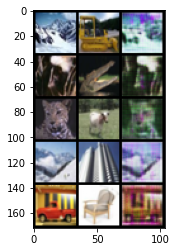

Testing generator - g_loss = 0.013956397771835327


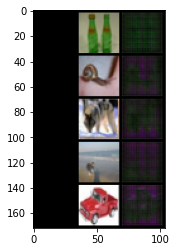

Testing classifier - Epoch 0 c_loss = 1.9081655740737915 acc = 0.2854
Training generator+classifier - Epoch 1 loss = 0.7584608197212219
Testing generator - g_loss = 0.014221039600670338
Testing generator - g_loss = 0.012863460928201675
Testing classifier - Epoch 1 c_loss = 1.8201017379760742 acc = 0.3392
Training generator+classifier - Epoch 2 loss = 0.7123752236366272
Testing generator - g_loss = 0.017437729984521866
Testing generator - g_loss = 0.01593822054564953
Testing classifier - Epoch 2 c_loss = 2.011681318283081 acc = 0.3406
Training generator+classifier - Epoch 3 loss = 0.6761439442634583
Testing generator - g_loss = 0.013853364624083042
Testing generator - g_loss = 0.014991942793130875
Testing classifier - Epoch 3 c_loss = 1.6131478548049927 acc = 0.405
Training generator+classifier - Epoch 4 loss = 0.64825040102005
Testing generator - g_loss = 0.01754886656999588
Testing generator - g_loss = 0.010370934382081032
Testing classifier - Epoch 4 c_loss = 1.5131278038024902 acc =

In [ ]:
# Training and test
mse_criterion = mse_criterion = nn.MSELoss()
ce_criterion = nn.CrossEntropyLoss()

criterion = EndToEndLoss(alpha=0.7)


for epoch in range(100):
    show = False
    if epoch % 10 == 0:
        show = True
    train_end_to_end_model(train_loader, epoch, model_end_to_end, criterion)
    generator = model_end_to_end.model_generator
    test_generator(test_cifa_100, generator, mse_criterion, show=show)
    test_generator_black(test_cifa_100, generator, mse_criterion, show=show)
    test_classifier(test_loader, model_end_to_end, ce_criterion)

# Old results 

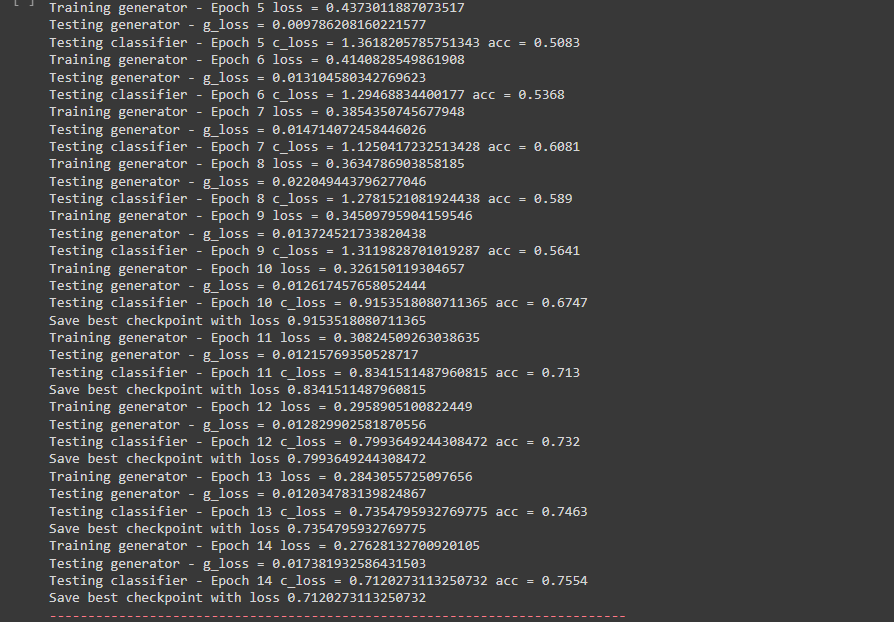